In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

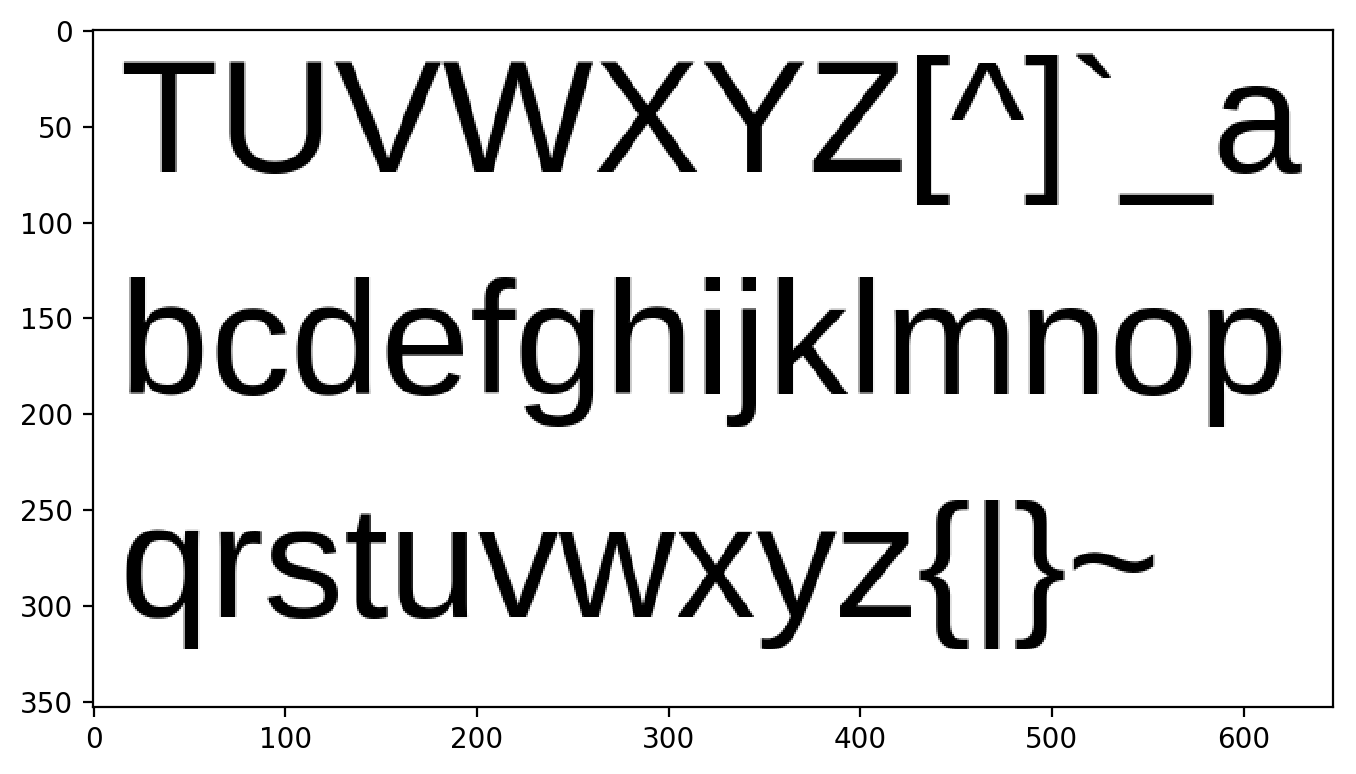

In [2]:
img = cv2.imread('pengcit2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img, cmap='gray')
plt.show()

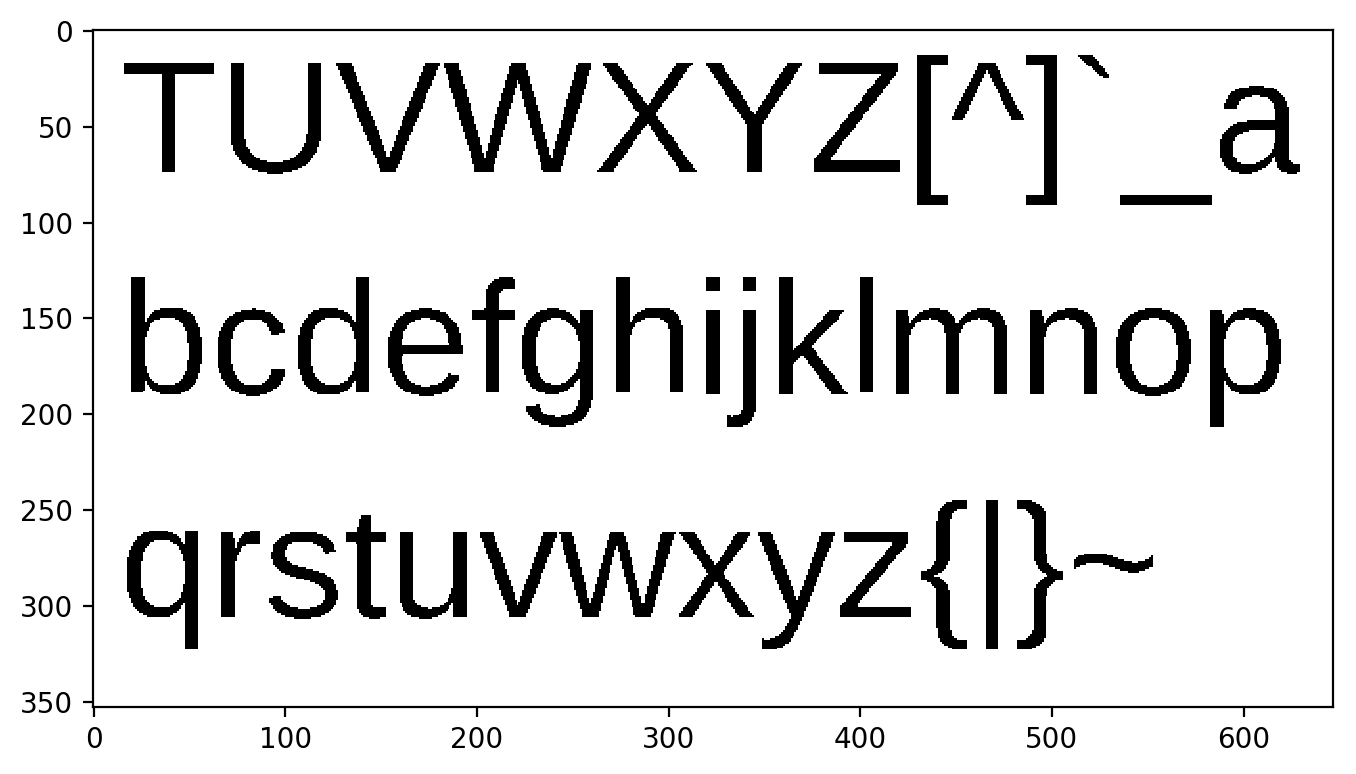

In [3]:
def to_rgb(img):
    h, w = img.shape
    res = np.ones((h,w,3))
    for y in range(h):
        for x in range(w):
            res[y][x] *= img[y][x]
    return res.astype(np.uint8)

def to_grayscale(img):
    return np.vectorize(lambda x: 255 if x == 0 else 0)(img)

def to_bitmap(img, threshold=110):
    return np.vectorize(lambda x: 1 if x < threshold else 0)(img)

threshold = 70
img_binary = np.vectorize(lambda x: 255 if x > threshold else 0)(img)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img_binary, cmap='gray')
plt.show()

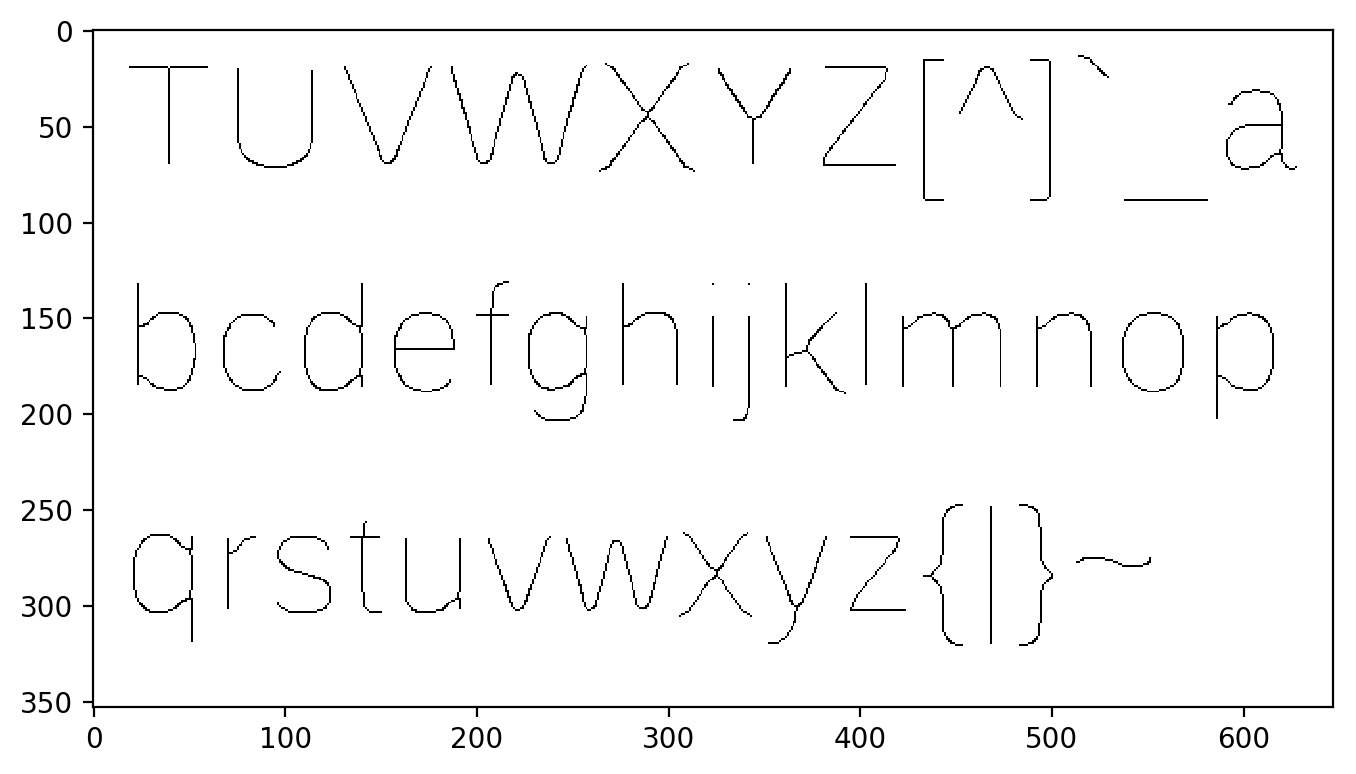

In [12]:
def generate_neighbour(img, y, x):
    h, w = img.shape
    p2 = img[y-1][x] if y > 0 else 0
    p3 = img[y-1][x+1] if y > 0 and x < w-1 else 0
    p4 = img[y][x+1] if x < w-1 else 0
    p5 = img[y+1][x+1] if y < h-1 and x < w-1 else 0
    p6 = img[y+1][x] if y < h-1 else 0
    p7 = img[y+1][x-1] if y < h-1 and x > 0 else 0
    p8 = img[y][x-1] if x > 0 else 0
    p9 = img[y-1][x-1] if y > 0 and x > 0 else 0
    return [p2,p3,p4,p5,p6,p7,p8,p9]

def check_delete(image, y, x):
    if image[y][x] == 0:
        return False
    ps = generate_neighbour(image, y, x)
    np = len(list(filter(lambda x : x != 0, ps)))
    sp = 0
    for i in range(len(ps)):
        j = (i + 1) % len(ps)
        sp += 1 if ps[i] != 0 and ps[j] == 0 else 0
    ret = (2 <= np) and (np <= 6) and (sp == 1) and (ps[2] == 0 or ps[4] == 0 or (ps[0] == 0 and ps[6] == 0))
    return ret

def check_delete_2(image, y, x):
    if image[y][x] == 0:
        return False
    ps = generate_neighbour(image, y, x)
    np = len(list(filter(lambda x : x != 0, ps)))
    sp = 0
    for i in range(len(ps)):
        j = (i + 1) % len(ps)
        sp += 1 if ps[i] != 0 and ps[j] == 0 else 0
    ret = (2 <= np) and (np <= 6) and (sp == 1) and (ps[0] == 0 or ps[6] == 0 or (ps[2] == 0 and ps[4] == 0))
    return ret

def thinning(img):
    height, width = img.shape
    img = img.copy()
    change = True
    while change:
        must_delete = []
        change = False
        for y in range(height):
            for x in range(width):
                if check_delete(img, y, x):
                    change = True
                    must_delete += [(x,y)]
        for v in must_delete:
            img[v[1]][v[0]] = 0

        must_delete = []
        for y in range(height):
            for x in range(width):
                if check_delete_2(img, y, x):
                    change = True
                    must_delete += [(x,y)]
        for v in must_delete:
            img[v[1]][v[0]] = 0
        must_delete = []
    return img

img_binary = to_bitmap(img)
img_thinned = thinning(img_binary)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(to_grayscale(img_thinned), cmap='gray')
plt.show()

In [6]:
def is_corner(img, y, x):
    return img[y][x] != 0 and sum(generate_neighbour(img, y, x)) == 1

def is_intersection(img, y, x):
    neighbours = generate_neighbour(img, y, x)
    n = sum(neighbours)
    sp = 0
    for i in range(len(neighbours)):
        j = (i + 1) % len(neighbours)
        sp += 1 if neighbours[i] != 0 and neighbours[j] == 0 else 0
    return img[y][x] != 0 and n > 2 and sp > 2

def get_corner_and_intersection(img):
    h, w = img.shape
    corners = []
    intersections = []
    for y in range(h):
        for x in range(w):
            if is_corner(img, y, x):
                corners += [(x, y)]
            if is_intersection(img, y, x):
                intersections += [(x, y)]
    return corners, intersections

# img_points = to_rgb(to_grayscale(img_thinned))
# corners, intersections = get_corner_and_intersection(img_thinned)
# for x, y in corners:
#     cv2.circle(img_points, (x, y), 5, (255,0,0))
# for x, y in intersections:
#     cv2.circle(img_points, (x, y), 5, (0,0,255))
    
# print("corners: %d" % len(corners))
# print("intersections: %d" % len(intersections))

# plt.figure(figsize=(8, 6), dpi=200)
# plt.imshow(img_points)
# plt.show()

In [ ]:
def get_objects_corners_and_intersections(img):
    img = img.copy()
    visited = np.zeros(img.shape)
    h, w = img.shape
    dx = [0, 1, 1, 1, 0, -1, -1, -1]
    dy = [-1, -1, 0, 1, 1, 1, 0, -1]
    
    res_corners = []
    res_intersections = []
    res_upper_bound = []
    res_lower_bound = []
    
    for y in range(h):
        for x in range(w):
            if img[y][x] != 0:
                
                corners = []
                intersections = []
                upper_bound = (w, h)
                lower_bound = (0, 0)
                perimeter = 0
                
                stack = [(x,y)]
                while len(stack) > 0:
                    cx, cy = stack.pop()
                    if visited[cy][cx] == 1:
                        continue
                    visited[cy][cx] = 1
                    
                    upper_bound = (min(cx, upper_bound[0]), min(cy, upper_bound[1]))
                    lower_bound = (max(cx, lower_bound[0]), max(cy, lower_bound[1]))
                    perimeter += 1
                    if is_corner(img, cy, cx):
                        corners.append((cx, cy))
                    if is_intersection(img, cy, cx):
                        intersections.append((cx, cy))
                        
                    for ddx, ddy in zip(dx, dy):
                        nx = cx + ddx
                        ny = cy + ddy
                        if nx >= 0 and nx < w and ny >= 0 and ny < h and visited[ny][nx] == 0 and img[ny][nx] != 0:
                            stack.append((nx, ny))
                            
                # remove some corners
                real_corners = []
                for i, corner in enumerate(corners):
                    real_corners += [corner]
                    for intersect in intersections:
                        # there is intersection point near this corner point
                        if np.linalg.norm(np.array(corner)-np.array(intersect)) < perimeter * 0.05:
                            real_corners.pop()
                            
                            # remove corner until the corner are gone
                            current_corner = corner
                            s = 1
                            while s == 1:
                                img[current_corner[1]][current_corner[0]] = 0
                                ns = generate_neighbour(img, current_corner[1], current_corner[0])
                                s = 0
                                for direction_i, val in enumerate(ns):
                                    s += val
                                    if val > 0:
                                        current_corner = (
                                            current_corner[0] + dx[direction_i],
                                            current_corner[1] + dy[direction_i]
                                        )
                                        
                            break
                                        
                # recalculate intersections
                real_intersections = []
                for intersection in intersections:
                    if is_intersection(img, intersection[1], intersection[0]):
                        real_intersections += [intersection]
                
                if perimeter > 20:
                    res_upper_bound.append(upper_bound)
                    res_lower_bound.append(lower_bound)
                    res_corners.append(real_corners)
                    res_intersections.append(real_intersections)
                
    return res_corners, res_intersections, res_upper_bound, res_lower_bound

objects_corners, objects_intersections, upper_bounds, lower_bounds = get_objects_corners_and_intersections(img_thinned)

for corners, intersections, upper_bound, lower_bound in zip(objects_corners, objects_intersections, upper_bounds, lower_bounds):
    cv2.rectangle(
        img_points,
        (upper_bound[0] - 1, upper_bound[1] - 1),
        (lower_bound[0] + 1, lower_bound[1] + 1),
        (0,255,0)
    )
    for x, y in corners:
        cv2.circle(img_points, (x, y), 5, (255,0,0))
    for x, y in intersections:
        cv2.circle(img_points, (x, y), 5, (0,0,255))
        
cv2.imwrite("res.jpg", img_points)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img_points)
plt.show()

90.0
[(408, 19), (409, 19), (410, 19), (411, 19), (412, 19), (413, 19), (414, 20), (414, 21), (413, 22), (413, 23)]
90.0
[(414, 264), (415, 264), (416, 264), (417, 264), (418, 264), (419, 264), (420, 265), (420, 266), (419, 267), (419, 268)]
crit points: 2


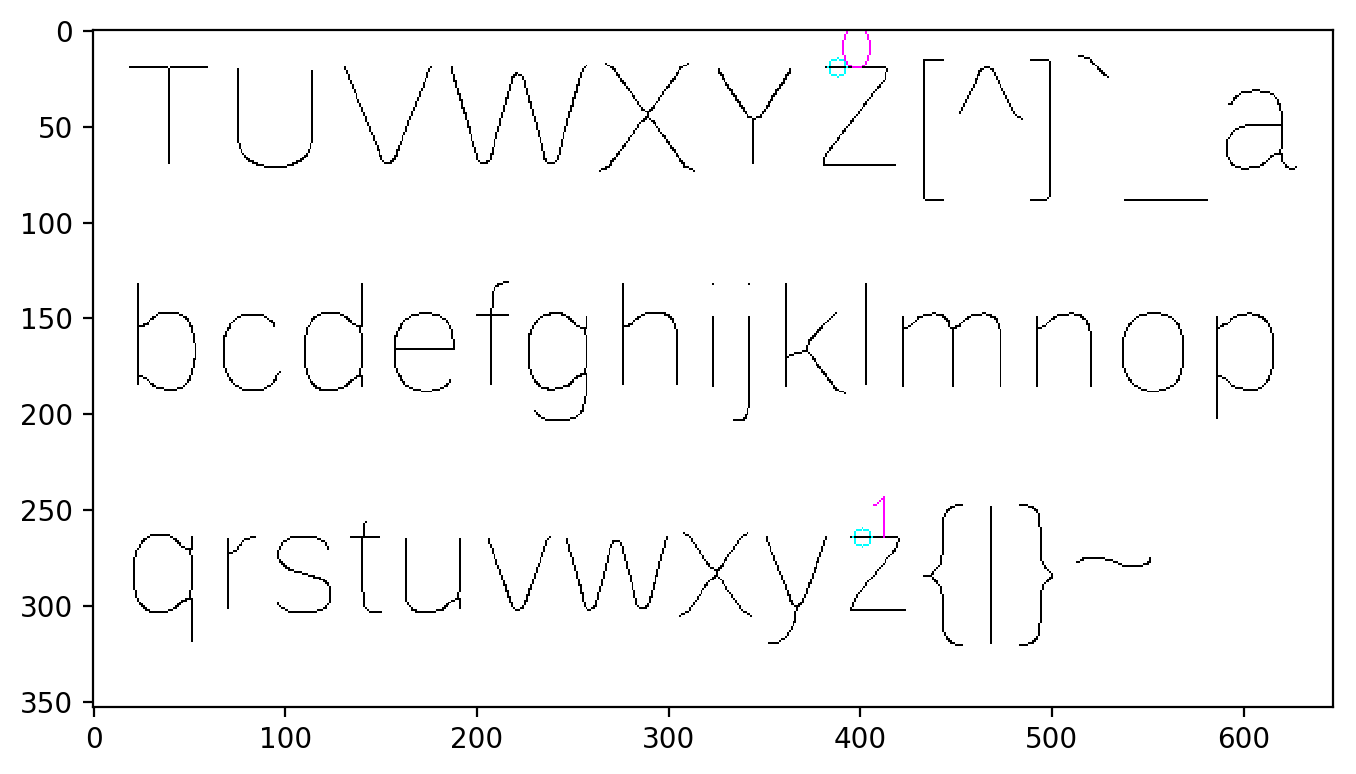

In [17]:
import math, numpy

def is_critical_point(last_ten):
    nx, ny = last_ten[0][0] - last_ten[5][0], last_ten[0][1] - last_ten[5][1]
    tx, ty = last_ten[5][0] - last_ten[9][0], last_ten[5][1] - last_ten[9][1]
    temp = ((nx*tx) + (ny*ty)) / ((math.sqrt((nx**2)+(ny**2))*(math.sqrt((tx**2)+(ty**2)))))
    teta = numpy.arccos(temp)
    pi = numpy.arccos(-1)
    sudut = teta * 180 / pi
    if sudut >= 90:
        print(sudut)
        print(last_ten)
        return True
    else :
        return False
                     
def get_critical_points(img):
    img = img.copy()
    visited = np.zeros(img.shape)
    h, w = img.shape
    dx = [0, 1, 1, 1, 0, -1, -1, -1]
    dy = [-1, -1, 0, 1, 1, 1, 0, -1]
    
    for y in range(h):
        for x in range(w):
            neighbours = generate_neighbour(img, y, x)
            n = sum(neighbours)
            sp = 0
            for i in range(len(neighbours)):
                j = (i + 1) % len(neighbours)
                sp += 1 if neighbours[i] != 0 and neighbours[j] == 0 else 0
            if n >= 3 and sp == 2:
                img[y][x] = 0
    
    crit_points = []
    for y in range(h):
        for x in range(w):
            if img[y][x] != 0 and is_corner(img, y, x):
                last_ten = []
                stack = [(x,y)]
                while len(stack) > 0:
                    cx, cy = stack.pop()
                    if visited[cy][cx] == 1:
                        continue
                    visited[cy][cx] = 1
                    
                    if len(last_ten) >= 10:
                        last_ten.append((cx, cy))
                        if is_critical_point(last_ten[-10:]):
                            crit_points.append((last_ten[5][0], last_ten[5][1]))
                            last_ten =[]
                    else :
                        last_ten.append((cx, cy))
                        
                    if is_intersection(img, cy, cx) or is_corner(img, cy, cx):
                        last_ten = []
                    
                    for ddx, ddy in zip(dx, dy):
                        nx = cx + ddx
                        ny = cy + ddy
                        if nx >= 0 and nx < w and ny >= 0 and ny < h and visited[ny][nx] == 0 and img[ny][nx] != 0:
                            stack.append((nx, ny))
                            
    return crit_points

crit_points = get_critical_points(img_thinned)

print("crit points: %d" %len(crit_points))

img_points = to_rgb(to_grayscale(img_thinned))
i = 0
for x, y in crit_points:
    cv2.circle(img_points, (x, y), 5, (0,255,255))
    cv2.putText(img_points, str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255))
    i += 1

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img_points)
plt.show()

In [ ]:
objects_corners, objects_intersections, upper_bounds, lower_bounds = get_objects_corners_and_intersections(img_thinned)

predictions = []
for corners, intersections, upper_bound, lower_bound in zip(objects_corners, objects_intersections, upper_bounds, lower_bounds):
    object_width = lower_bound[0] - upper_bound[0]
    object_height = lower_bound[1] - upper_bound[1]
      
    guess = None
    if len(corners) == 0:
        if len(intersections) == 0:
            guess = 0
        elif len(intersections) == 2:
            guess = 8
    elif len(corners) == 1:
        if len(intersections) == 1:
            corner_y = corners[0][1]
            intersection_y = intersections[0][1]
            if corner_y < intersection_y:
                guess = 6
            else:
                guess = 9
    elif len(corners) == 2:
        if len(intersections) == 1:
            guess = 4
        elif len(intersections) == 0:
            if corners[0][0] - upper_bound[0] < object_width / 2 and corners[1][0] - upper_bound[0] < object_width / 2:
                guess = 7
            elif (corners[0][0] - corners[1][0]) * (corners[0][1] - corners[1][1]) > 0:
                guess = 2
            else:
                guess = 5
                
    elif len(corners) == 3:
        if len(intersections) == 1:
            intersection_x = intersections[0][0]
            corner_x = max(map(lambda x: x[0], corners))
            if intersection_x > corner_x:
                guess = 3
            else:
                guess = 1
    predictions.append(guess)

img_points = to_rgb(to_grayscale(img_thinned))
for corners, intersections, upper_bound, lower_bound, p in zip(objects_corners, objects_intersections, upper_bounds, lower_bounds, predictions):
    cv2.rectangle(
        img_points,
        (upper_bound[0] - 1, upper_bound[1] - 1),
        (lower_bound[0] + 1, lower_bound[1] + 1),
        (0,255,0)
    )
    for x, y in corners:
        cv2.circle(img_points, (x, y), 5, (255,0,0))
    for x, y in intersections:
        cv2.circle(img_points, (x, y), 5, (0,0,255))
        
    if p is not None:
        cv2.putText(img_points, str(p), (upper_bound[0], lower_bound[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255))

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img_points)
plt.show()